In [94]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

butlerN = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir")
butlerY = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir_1")
dataid = {'tract':0, 'patch':"3,9", 'filter':'r'}
 
sourcesN = butlerN.get('deepCoadd_src', dataid)
print "Found %d sources in this dataset - Regular astrometry"%len(sources)
sourcesY = butlerY.get('deepCoadd_src', dataid)
print "Found %d sources in this dataset - Simultaneous astrometry"%len(sources)

mdN = butlerN.get("deepCoadd_md", dataid, immediate=True)
calibN = afwImage.Calib(mdN)
mdY = butlerY.get("deepCoadd_md", dataid, immediate=True)
calibY = afwImage.Calib(mdY)

# Match both catalogs
match = afwTable.matchRaDec(sourcesN, sourcesY, afwGeom.Angle(1./3600., afwGeom.degrees))
print "%d matches found"%len(match)

Found 14013 sources in this dataset - Regular astrometry
Found 14013 sources in this dataset - Simultaneous astrometry
13768 matches found


In [105]:
import math

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag","base_ClassificationExtendedness_flag"]
schema = sourcesN.getSchema()
flagKey = []
for f in Flags :
    key = schema[f].asKey()
    flagKey.append(key)
    
extendKey = schema["base_ClassificationExtendedness_value"].asKey()

fluxKey = schema["base_CircularApertureFlux_4_5_flux"].asKey()
fluxSigmaKey = schema["base_CircularApertureFlux_4_5_fluxSigma"].asKey()
xxKey = schema["base_SdssShape_xx"].asKey()
yyKey = schema["base_SdssShape_yy"].asKey()
parentKey = schema["parent"].asKey()

count = 0
Mag = []
Ang = []
Dx = []
Dy = []
XxN = []
YyN = []
for m in match:
    srcN = m.first
    srcY = m.second
    
    for f in flagKey :
        if srcN.get(f) or srcY.get(f) :
            continue
    if srcY.get(extendKey)>0.5 :
        continue
    
    flux = srcY.get(fluxKey)
    fluxSigma = srcY.get(fluxSigmaKey)
    if flux /fluxSigma < 5 :
        continue
    if flux > 0. :
        mag = calibY.getMagnitude(flux)
    else :
        continue
    if mag < 17.5 or mag > 23 :
        continue
     
    # Remove blended objects
#    if srcN.get(parentKey) != 0 or srcY.get(parentKey) != 0 :
#        continue
    fpN = srcN.getFootprint()
    if fpN is not None and len(fpN.getPeaks()) > 1 :
        continue
    fpY = srcY.getFootprint()
    if fpY is not None and len(fpY.getPeaks()) > 1 :
        continue
    
    ang = afwGeom.radToMas(m.distance)
    if ang == 0 :
        continue
    
    count += 1
    
    Ang.append(ang)
    
    xxN = srcN.get(xxKey)
    yyN = srcN.get(yyKey)
    xxY = srcY.get(xxKey)
    yyY = srcY.get(yyKey)
    
    XxN.append(xxN)
    YyN.append(yyN)
    
    dx = xxN-xxY
    dy = yyN-yyY
     
    Dx.append(dx)
    Dy.append(dy)
    
    Mag.append(mag)
    
print "Nbr. of sources kept after all selection cuts applied : %d"%count

Nbr. of sources kept after all selection cuts applied : 153


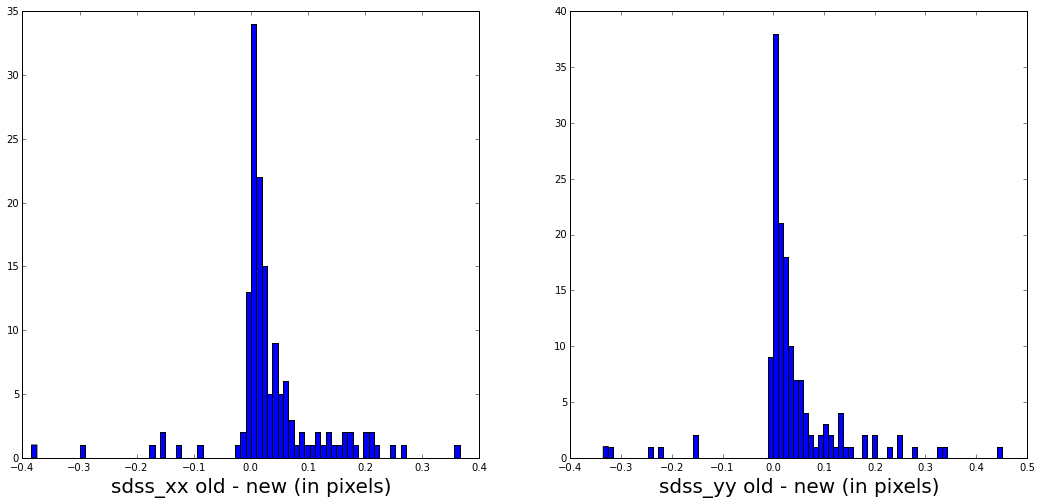

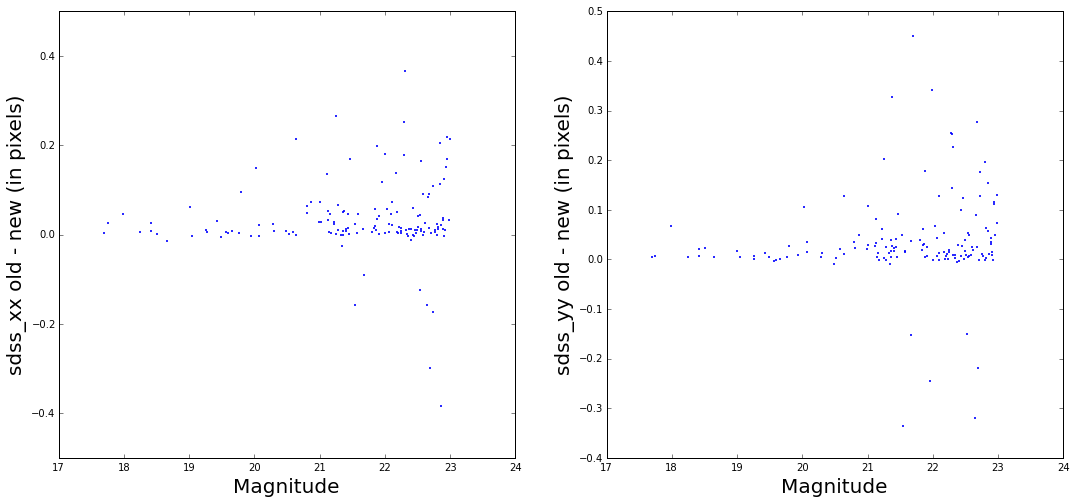

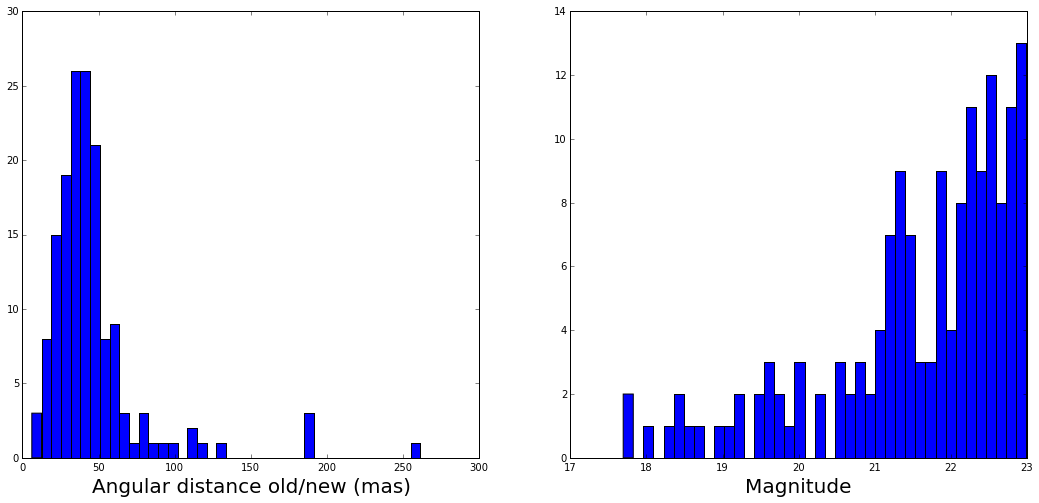

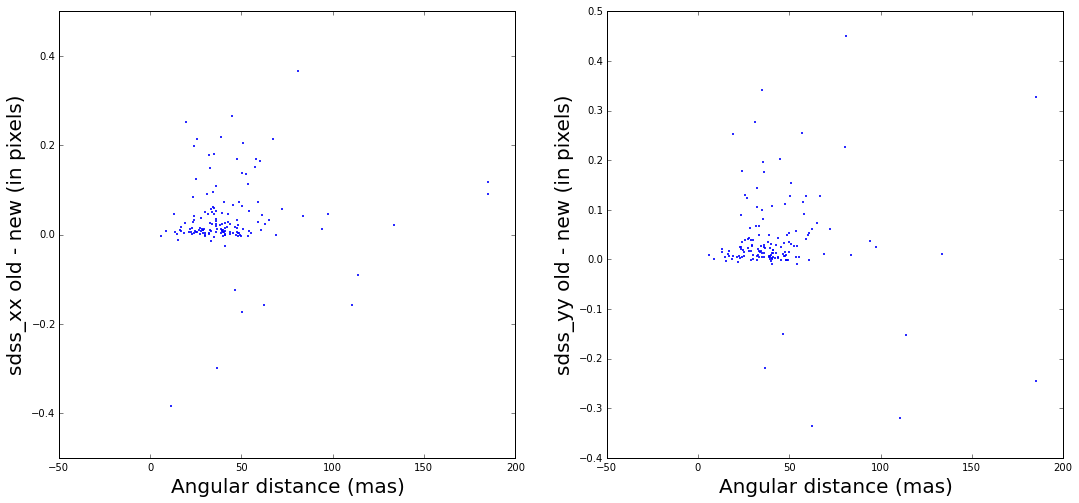

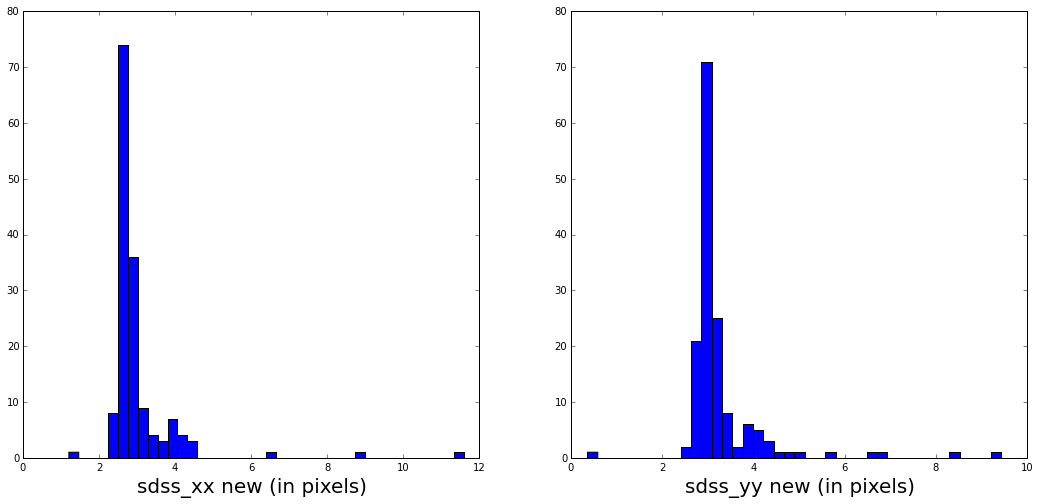

In [109]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

idx = np.where(abs(np.asarray(Dx)) < 0.5) 
idy = np.where(abs(np.asarray(Dy)) < 0.5)

idx2 = np.where(np.asarray(XxN)<20)
idy2 = np.where(np.asarray(YyN)<20)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,8))
ax0.hist(np.asarray(Dx)[idx], bins=80)
ax1.hist(np.asarray(Dy)[idy], bins=80)
ax0.set_xlabel("sdss_xx old - new (in pixels)", fontsize=20)
ax1.set_xlabel("sdss_yy old - new (in pixels)", fontsize=20)

#fig.suptitle("Single CCD astrometry", fontsize=20)
#fig.suptitle("Simultaneous astrometry", fontsize=20)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(18,8))
ax2.scatter(np.asarray(Mag)[idx], np.asarray(Dx)[idx], s=1, color='b')
ax3.scatter(np.asarray(Mag)[idy], np.asarray(Dy)[idy], s=1, color='b')
ax2.set_xlabel("Magnitude", fontsize=20)
ax2.set_ylabel("sdss_xx old - new (in pixels)", fontsize=20)
ax3.set_xlabel("Magnitude", fontsize=20)
ax3.set_ylabel("sdss_yy old - new (in pixels)", fontsize=20)

fig, (ax4, ax5) = plt.subplots(ncols=2, figsize=(18,8))
ax4.hist(np.asarray(Ang), bins=40)
ax4.set_xlabel("Angular distance old/new (mas)", fontsize=20)
ax5.hist(np.asarray(Mag), bins=40)
ax5.set_xlabel("Magnitude", fontsize=20)

fig, (ax6, ax7) = plt.subplots(ncols=2, figsize=(18,8))
ax6.scatter(np.asarray(Ang)[idx], np.asarray(Dx)[idx], s=1, color='b')
ax6.set_xlabel("Angular distance (mas)", fontsize=20)
ax6.set_ylabel("sdss_xx old - new (in pixels)", fontsize=20)
ax7.scatter(np.asarray(Ang)[idy], np.asarray(Dy)[idy], s=1, color='b')
ax7.set_xlabel("Angular distance (mas)", fontsize=20)
ax7.set_ylabel("sdss_yy old - new (in pixels)", fontsize=20)

fig, (ax8, ax9) = plt.subplots(ncols=2, figsize=(18,8))
ax8.hist(np.asarray(XxN)[idx2], bins=40)
ax8.set_xlabel("sdss_xx new (in pixels)", fontsize=20)
ax9.hist(np.asarray(YyN)[idy2], bins=40)
ax9.set_xlabel("sdss_yy new (in pixels)", fontsize=20)